#### Aim

It is your job to predict the sales price for each house. <br>
For each Id in the test set, you must predict the value of the SalePrice variable. 

##### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


from mpl_toolkits.mplot3d import Axes3D

import math
import shap
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Import Data

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Exploratory Data Analysis

In [4]:
df_train.shape

(1460, 81)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

It can be seen below that LotFrontage and GarageYrBlt are both asymmetrically distributed therefore the median should be used for imputation rather than mean

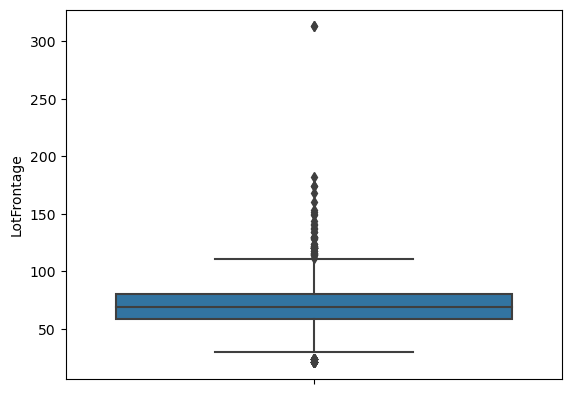

In [6]:
sns.boxplot( y=df_train["LotFrontage"] );
plt.show()

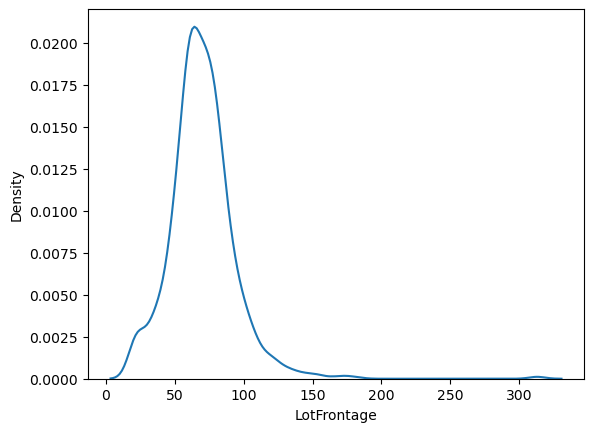

In [7]:
data = df_train["LotFrontage"]
res = sns.kdeplot(data)
plt.show()

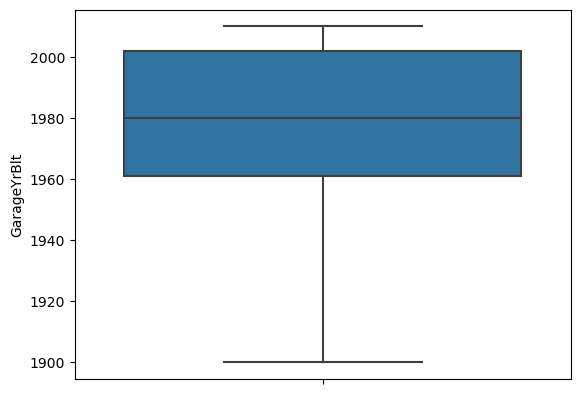

In [8]:
sns.boxplot( y=df_train["GarageYrBlt"] );
plt.show()

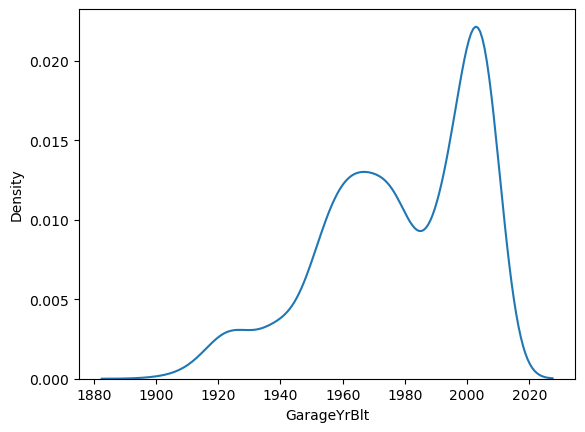

In [9]:
data = df_train["GarageYrBlt"]
res = sns.kdeplot(data)
plt.show()

#### Variable Correlation

<AxesSubplot:>

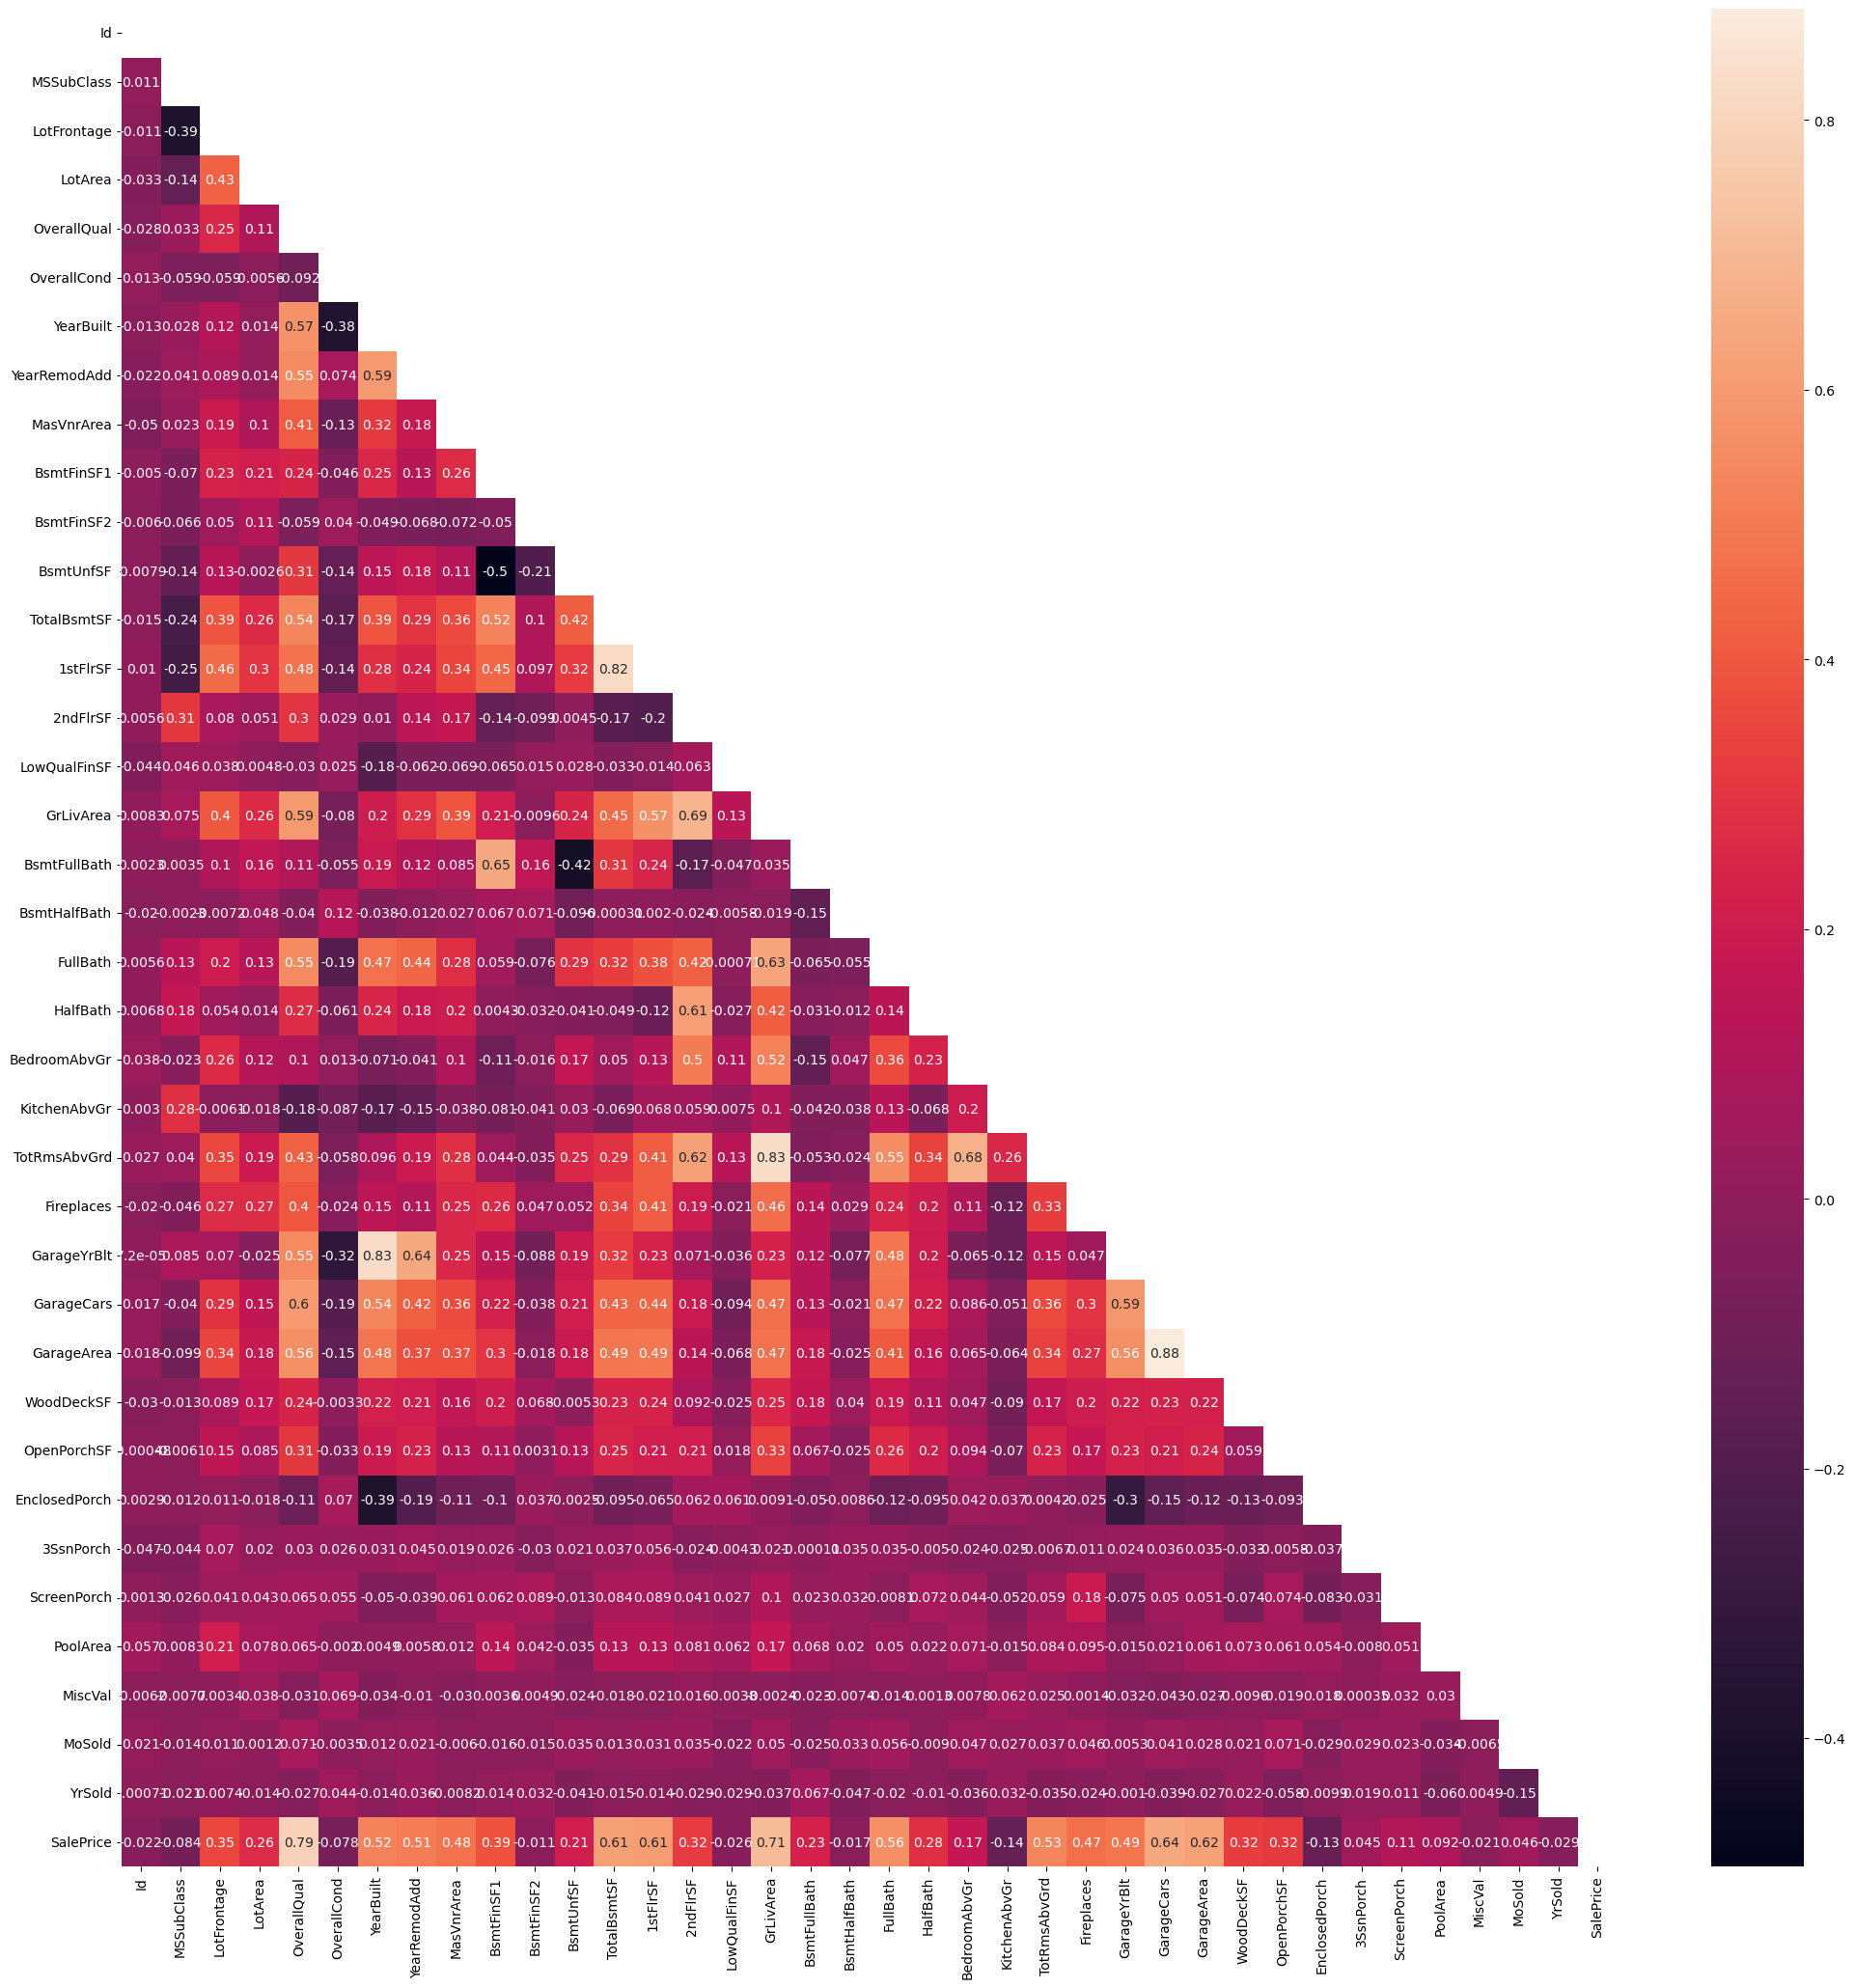

In [10]:
#Let us check which features are correlated

fig, ax = plt.subplots(figsize=(25, 25)) 
mask = np.zeros_like(df_train.corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(df_train.corr(), mask= mask, ax= ax, annot= True)

#### Data Cleaning

There are some features that have many missing values - these need to be dropped

Below we drop the features that have majority missing values

In [11]:
df_train_dropped_missing = df_train.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu' ])

In [12]:
df_train_dropped_missing.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinType2      38
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath 

In [13]:
df_view_columns_with_missing = df_train_dropped_missing[['LotFrontage', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtExposure', 
                                                 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 
                                                'GarageFinish', 'GarageQual', 'GarageCond']]

In [14]:
df_view_columns_with_missing.head()

,LotFrontage,BsmtQual,BsmtCond,BsmtExposure,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
0,65.0,Gd,TA,No,No,GLQ,Unf,SBrkr,Attchd,2003.0,RFn,TA,TA
1,80.0,Gd,TA,Gd,Gd,ALQ,Unf,SBrkr,Attchd,1976.0,RFn,TA,TA
2,68.0,Gd,TA,Mn,Mn,GLQ,Unf,SBrkr,Attchd,2001.0,RFn,TA,TA
3,60.0,TA,Gd,No,No,ALQ,Unf,SBrkr,Detchd,1998.0,Unf,TA,TA
4,84.0,Gd,TA,Av,Av,GLQ,Unf,SBrkr,Attchd,2000.0,RFn,TA,TA


In [15]:
df_view_columns_with_missing.describe()

,LotFrontage,GarageYrBlt
count,1201.000000,1379.000000
mean,70.049958,1978.506164
std,24.284752,24.689725
min,21.000000,1900.000000
25%,59.000000,1961.000000
50%,69.000000,1980.000000
75%,80.000000,2002.000000
max,313.000000,2010.000000


Next, let us deal with the features where we will impute values

For the categorical variables we will impute using the mode

For the continuous variables we will impute using the median as this metric is not influenced by outliers

###### Replace continuous features

In [16]:
df_train_dropped_missing['LotFrontage'] = df_train_dropped_missing['LotFrontage'].fillna(df_train_dropped_missing['LotFrontage'].median())
df_train_dropped_missing['GarageYrBlt'] = df_train_dropped_missing['GarageYrBlt'].fillna(df_train_dropped_missing['GarageYrBlt'].median())

##### Replace categorical features

In [17]:
df_train_dropped_missing['BsmtCond'].fillna(df_train_dropped_missing['BsmtCond'].mode()[0], inplace=True)
df_train_dropped_missing['BsmtQual'].fillna(df_train_dropped_missing['BsmtQual'].mode()[0], inplace=True)
df_train_dropped_missing['BsmtExposure'].fillna(df_train_dropped_missing['BsmtExposure'].mode()[0], inplace=True)
df_train_dropped_missing['BsmtFinType1'].fillna(df_train_dropped_missing['BsmtFinType1'].mode()[0], inplace=True)
df_train_dropped_missing['BsmtFinType2'].fillna(df_train_dropped_missing['BsmtFinType2'].mode()[0], inplace=True)
df_train_dropped_missing['Electrical'].fillna(df_train_dropped_missing['Electrical'].mode()[0], inplace=True)
df_train_dropped_missing['GarageType'].fillna(df_train_dropped_missing['GarageType'].mode()[0], inplace=True)
df_train_dropped_missing['GarageFinish'].fillna(df_train_dropped_missing['GarageFinish'].mode()[0], inplace=True)
df_train_dropped_missing['GarageQual'].fillna(df_train_dropped_missing['GarageQual'].mode()[0], inplace=True)
df_train_dropped_missing['GarageCond'].fillna(df_train_dropped_missing['GarageCond'].mode()[0], inplace=True)
df_train_dropped_missing['MasVnrType'].fillna(df_train_dropped_missing['MasVnrType'].mode()[0], inplace=True)
df_train_dropped_missing['MasVnrArea'].fillna(df_train_dropped_missing['MasVnrArea'].mode()[0], inplace=True)

Check that all values have been replaced

In [18]:
df_train_dropped_missing.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

### Dealing with categorical variables

In [19]:
df_train_cleaned = df_train_dropped_missing.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [20]:
df_train_cleaned = df_train_dropped_missing.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

In [21]:
df_train_cleaned.shape

(1460, 76)

#### Outcome variable analysis

In [22]:
df_train_cleaned['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Model Preparation

One hot encode categorical features

In [23]:
cat_features_list2=df_train_cleaned.select_dtypes(include='object').columns.to_list()
print("Categorical features list: ", cat_features_list2) 
print("Amount of categorical features = ", len(cat_features_list2))

Categorical features list:  ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
Amount of categorical features =  38


In [24]:
df_model = pd.get_dummies(df_train_cleaned, columns=cat_features_list2)

In [25]:
df_model.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_c (all),MSZoning_fv,MSZoning_rh,MSZoning_rl,MSZoning_rm,Street_grvl,Street_pave,LotShape_ir1,LotShape_ir2,LotShape_ir3,LotShape_reg,LandContour_bnk,LandContour_hls,LandContour_low,LandContour_lvl,Utilities_allpub,Utilities_nosewa,LotConfig_corner,LotConfig_culdsac,LotConfig_fr2,LotConfig_fr3,LotConfig_inside,LandSlope_gtl,LandSlope_mod,LandSlope_sev,Neighborhood_blmngtn,Neighborhood_blueste,Neighborhood_brdale,Neighborhood_brkside,Neighborhood_clearcr,Neighborhood_collgcr,Neighborhood_crawfor,Neighborhood_edwards,Neighborhood_gilbert,Neighborhood_idotrr,Neighborhood_meadowv,Neighborhood_mitchel,Neighborhood_names,Neighborhood_noridge,Neighborhood_npkvill,Neighborhood_nridght,Neighborhood_nwames,Neighborhood_oldtown,Neighborhood_sawyer,Neighborhood_sawyerw,Neighborhood_somerst,Neighborhood_stonebr,Neighborhood_swisu,Neighborhood_timber,Neighborhood_veenker,Condition1_artery,Condition1_feedr,Condition1_norm,Condition1_posa,Condition1_posn,Condition1_rrae,Condition1_rran,Condition1_rrne,Condition1_rrnn,Condition2_artery,Condition2_feedr,Condition2_norm,Condition2_posa,Condition2_posn,Condition2_rrae,Condition2_rran,Condition2_rrnn,BldgType_1fam,BldgType_2fmcon,BldgType_duplex,BldgType_twnhs,BldgType_twnhse,HouseStyle_1.5fin,HouseStyle_1.5unf,HouseStyle_1story,HouseStyle_2.5fin,HouseStyle_2.5unf,HouseStyle_2story,HouseStyle_sfoyer,HouseStyle_slvl,RoofStyle_flat,RoofStyle_gable,RoofStyle_gambrel,RoofStyle_hip,RoofStyle_mansard,RoofStyle_shed,RoofMatl_clytile,RoofMatl_compshg,RoofMatl_membran,RoofMatl_metal,RoofMatl_roll,RoofMatl_tar&grv,RoofMatl_wdshake,RoofMatl_wdshngl,Exterior1st_asbshng,Exterior1st_asphshn,Exterior1st_brkcomm,Exterior1st_brkface,Exterior1st_cblock,Exterior1st_cemntbd,Exterior1st_hdboard,Exterior1st_imstucc,Exterior1st_metalsd,Exterior1st_plywood,Exterior1st_stone,Exterior1st_stucco,Exterior1st_vinylsd,Exterior1st_wd sdng,Exterior1st_wdshing,Exterior2nd_asbshng,Exterior2nd_asphshn,Exterior2nd_brk cmn,Exterior2nd_brkface,Exterior2nd_cblock,Exterior2nd_cmentbd,Exterior2nd_hdboard,Exterior2nd_imstucc,Exterior2nd_metalsd,Exterior2nd_other,Exterior2nd_plywood,Exterior2nd_stone,Exterior2nd_stucco,Exterior2nd_vinylsd,Exterior2nd_wd sdng,Exterior2nd_wd shng,MasVnrType_brkcmn,MasVnrType_brkface,MasVnrType_none,MasVnrType_stone,ExterQual_ex,ExterQual_fa,ExterQual_gd,ExterQual_ta,ExterCond_ex,ExterCond_fa,ExterCond_gd,ExterCond_po,ExterCond_ta,Foundation_brktil,Foundation_cblock,Foundation_pconc,Foundation_slab,Foundation_stone,Foundation_wood,BsmtQual_ex,BsmtQual_fa,BsmtQual_gd,BsmtQual_ta,BsmtCond_fa,BsmtCond_gd,BsmtCond_po,BsmtCond_ta,BsmtExposure_av,BsmtExposure_gd,BsmtExposure_mn,BsmtExposure_no,BsmtFinType1_alq,BsmtFinType1_blq,BsmtFinType1_glq,BsmtFinType1_lwq,BsmtFinType1_rec,BsmtFinType1_unf,BsmtFinType2_alq,BsmtFinType2_blq,BsmtFinType2_glq,BsmtFinType2_lwq,BsmtFinType2_rec,BsmtFinType2_unf,Heating_floor,Heating_gasa,Heating_gasw,Heating_grav,Heating_othw,Heating_wall,HeatingQC_ex,HeatingQC_fa,HeatingQC_gd,HeatingQC_po,HeatingQC_ta,CentralAir_n,CentralAir_y,Electrical_fusea,Electrical_fusef,Electrical_fusep,Electrical_mix,Electrical_sbrkr,KitchenQual_ex,KitchenQual_fa,KitchenQual_gd,KitchenQual_ta,Functional_maj1,Functional_maj2,Functional_min1,Functional_min2,Functional_mod,Functional_sev,Functional_typ,GarageType_2types,GarageType_attchd,GarageType_basment,GarageType_builtin,GarageType_carport,GarageType_detchd,GarageFinish_fin,GarageFinish_rfn,GarageFinish_unf,GarageQual_ex,GarageQual_fa,GarageQual_gd,GarageQual_po,GarageQual_ta,GarageCond_ex,GarageCond_fa,GarageCond_gd,GarageCond_po,GarageCond_ta,PavedD

In [26]:
#Export df_model as csv to use in model build

cwd = os.getcwd()
path = cwd + "/df_model"
df_model.to_csv(path)

In [27]:
#Separating the dataset in x which are the features and y which is the label
feature_names=['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MSZoning_c (all)',
 'MSZoning_fv',
 'MSZoning_rh',
 'MSZoning_rl',
 'MSZoning_rm',
 'Street_grvl',
 'Street_pave',
 'LotShape_ir1',
 'LotShape_ir2',
 'LotShape_ir3',
 'LotShape_reg',
 'LandContour_bnk',
 'LandContour_hls',
 'LandContour_low',
 'LandContour_lvl',
 'Utilities_allpub',
 'Utilities_nosewa',
 'LotConfig_corner',
 'LotConfig_culdsac',
 'LotConfig_fr2',
 'LotConfig_fr3',
 'LotConfig_inside',
 'LandSlope_gtl',
 'LandSlope_mod',
 'LandSlope_sev',
 'Neighborhood_blmngtn',
 'Neighborhood_blueste',
 'Neighborhood_brdale',
 'Neighborhood_brkside',
 'Neighborhood_clearcr',
 'Neighborhood_collgcr',
 'Neighborhood_crawfor',
 'Neighborhood_edwards',
 'Neighborhood_gilbert',
 'Neighborhood_idotrr',
 'Neighborhood_meadowv',
 'Neighborhood_mitchel',
 'Neighborhood_names',
 'Neighborhood_noridge',
 'Neighborhood_npkvill',
 'Neighborhood_nridght',
 'Neighborhood_nwames',
 'Neighborhood_oldtown',
 'Neighborhood_sawyer',
 'Neighborhood_sawyerw',
 'Neighborhood_somerst',
 'Neighborhood_stonebr',
 'Neighborhood_swisu',
 'Neighborhood_timber',
 'Neighborhood_veenker',
 'Condition1_artery',
 'Condition1_feedr',
 'Condition1_norm',
 'Condition1_posa',
 'Condition1_posn',
 'Condition1_rrae',
 'Condition1_rran',
 'Condition1_rrne',
 'Condition1_rrnn',
 'Condition2_artery',
 'Condition2_feedr',
 'Condition2_norm',
 'Condition2_posa',
 'Condition2_posn',
 'Condition2_rrae',
 'Condition2_rran',
 'Condition2_rrnn',
 'BldgType_1fam',
 'BldgType_2fmcon',
 'BldgType_duplex',
 'BldgType_twnhs',
 'BldgType_twnhse',
 'HouseStyle_1.5fin',
 'HouseStyle_1.5unf',
 'HouseStyle_1story',
 'HouseStyle_2.5fin',
 'HouseStyle_2.5unf',
 'HouseStyle_2story',
 'HouseStyle_sfoyer',
 'HouseStyle_slvl',
 'RoofStyle_flat',
 'RoofStyle_gable',
 'RoofStyle_gambrel',
 'RoofStyle_hip',
 'RoofStyle_mansard',
 'RoofStyle_shed',
 'RoofMatl_clytile',
 'RoofMatl_compshg',
 'RoofMatl_membran',
 'RoofMatl_metal',
 'RoofMatl_roll',
 'RoofMatl_tar&grv',
 'RoofMatl_wdshake',
 'RoofMatl_wdshngl',
 'Exterior1st_asbshng',
 'Exterior1st_asphshn',
 'Exterior1st_brkcomm',
 'Exterior1st_brkface',
 'Exterior1st_cblock',
 'Exterior1st_cemntbd',
 'Exterior1st_hdboard',
 'Exterior1st_imstucc',
 'Exterior1st_metalsd',
 'Exterior1st_plywood',
 'Exterior1st_stone',
 'Exterior1st_stucco',
 'Exterior1st_vinylsd',
 'Exterior1st_wd sdng',
 'Exterior1st_wdshing',
 'Exterior2nd_asbshng',
 'Exterior2nd_asphshn',
 'Exterior2nd_brk cmn',
 'Exterior2nd_brkface',
 'Exterior2nd_cblock',
 'Exterior2nd_cmentbd',
 'Exterior2nd_hdboard',
 'Exterior2nd_imstucc',
 'Exterior2nd_metalsd',
 'Exterior2nd_other',
 'Exterior2nd_plywood',
 'Exterior2nd_stone',
 'Exterior2nd_stucco',
 'Exterior2nd_vinylsd',
 'Exterior2nd_wd sdng',
 'Exterior2nd_wd shng',
 'MasVnrType_brkcmn',
 'MasVnrType_brkface',
 'MasVnrType_none',
 'MasVnrType_stone',
 'ExterQual_ex',
 'ExterQual_fa',
 'ExterQual_gd',
 'ExterQual_ta',
 'ExterCond_ex',
 'ExterCond_fa',
 'ExterCond_gd',
 'ExterCond_po',
 'ExterCond_ta',
 'Foundation_brktil',
 'Foundation_cblock',
 'Foundation_pconc',
 'Foundation_slab',
 'Foundation_stone',
 'Foundation_wood',
 'BsmtQual_ex',
 'BsmtQual_fa',
 'BsmtQual_gd',
 'BsmtQual_ta',
 'BsmtCond_fa',
 'BsmtCond_gd',
 'BsmtCond_po',
 'BsmtCond_ta',
 'BsmtExposure_av',
 'BsmtExposure_gd',
 'BsmtExposure_mn',
 'BsmtExposure_no',
 'BsmtFinType1_alq',
 'BsmtFinType1_blq',
 'BsmtFinType1_glq',
 'BsmtFinType1_lwq',
 'BsmtFinType1_rec',
 'BsmtFinType1_unf',
 'BsmtFinType2_alq',
 'BsmtFinType2_blq',
 'BsmtFinType2_glq',
 'BsmtFinType2_lwq',
 'BsmtFinType2_rec',
 'BsmtFinType2_unf',
 'Heating_floor',
 'Heating_gasa',
 'Heating_gasw',
 'Heating_grav',
 'Heating_othw',
 'Heating_wall',
 'HeatingQC_ex',
 'HeatingQC_fa',
 'HeatingQC_gd',
 'HeatingQC_po',
 'HeatingQC_ta',
 'CentralAir_n',
 'CentralAir_y',
 'Electrical_fusea',
 'Electrical_fusef',
 'Electrical_fusep',
 'Electrical_mix',
 'Electrical_sbrkr',
 'KitchenQual_ex',
 'KitchenQual_fa',
 'KitchenQual_gd',
 'KitchenQual_ta',
 'Functional_maj1',
 'Functional_maj2',
 'Functional_min1',
 'Functional_min2',
 'Functional_mod',
 'Functional_sev',
 'Functional_typ',
 'GarageType_2types',
 'GarageType_attchd',
 'GarageType_basment',
 'GarageType_builtin',
 'GarageType_carport',
 'GarageType_detchd',
 'GarageFinish_fin',
 'GarageFinish_rfn',
 'GarageFinish_unf',
 'GarageQual_ex',
 'GarageQual_fa',
 'GarageQual_gd',
 'GarageQual_po',
 'GarageQual_ta',
 'GarageCond_ex',
 'GarageCond_fa',
 'GarageCond_gd',
 'GarageCond_po',
 'GarageCond_ta',
 'PavedDrive_n',
 'PavedDrive_p',
 'PavedDrive_y',
 'SaleType_cod',
 'SaleType_con',
 'SaleType_conld',
 'SaleType_conli',
 'SaleType_conlw',
 'SaleType_cwd',
 'SaleType_new',
 'SaleType_oth',
 'SaleType_wd',
 'SaleCondition_abnorml',
 'SaleCondition_adjland',
 'SaleCondition_alloca',
 'SaleCondition_family',
 'SaleCondition_normal',
 'SaleCondition_partial']
X = df_model[feature_names]
y = df_model[['SalePrice']]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

### Model Build

##### XGB Regressor

In [29]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
predictions = my_model.predict(X_test, iteration_range=(0, 5))

In [30]:
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 139347.6140504602


In [31]:
print("Mean Squared Error : " + str(mean_squared_error(y_test, predictions, squared=False)))

Mean Squared Error : 158008.15360882925


In [32]:
MSE = mean_squared_error(y_test, predictions, squared=False)

In [33]:
rsme = math.sqrt(MSE)  
print("Root Mean Square Error:")  
print(rsme)  

Root Mean Square Error:
397.5023944693028


In [34]:
explainer = shap.TreeExplainer(my_model, iteration_range=(0, 5))
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


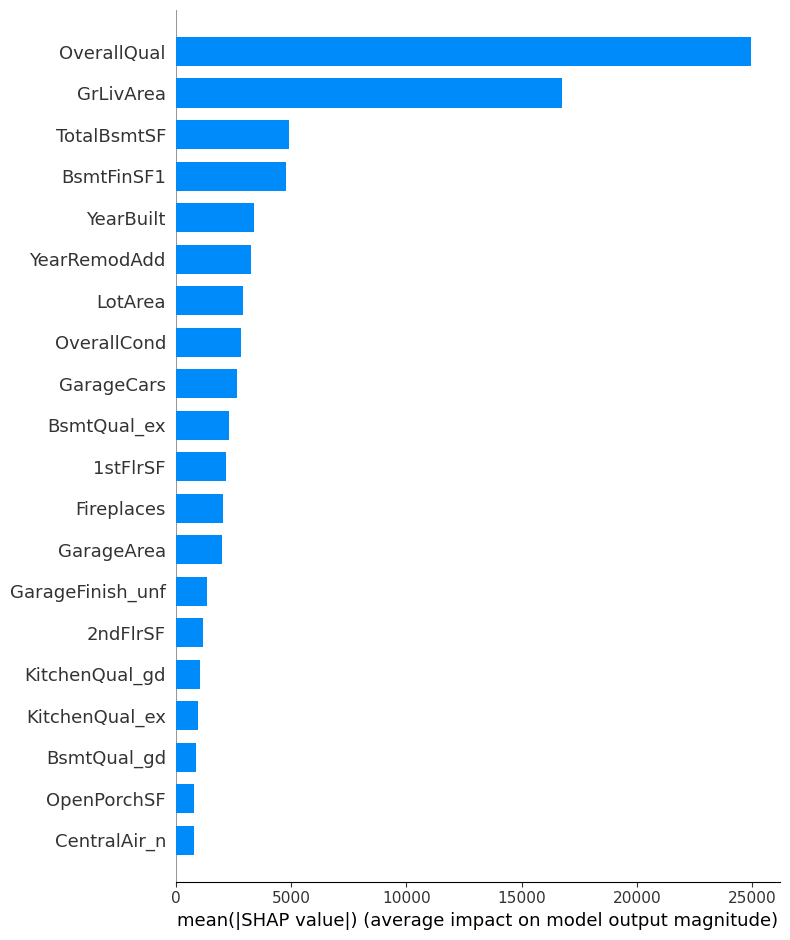

In [35]:
shap.summary_plot(shap_values, features=X_train, feature_names=df_model[feature_names].columns, plot_type='bar')

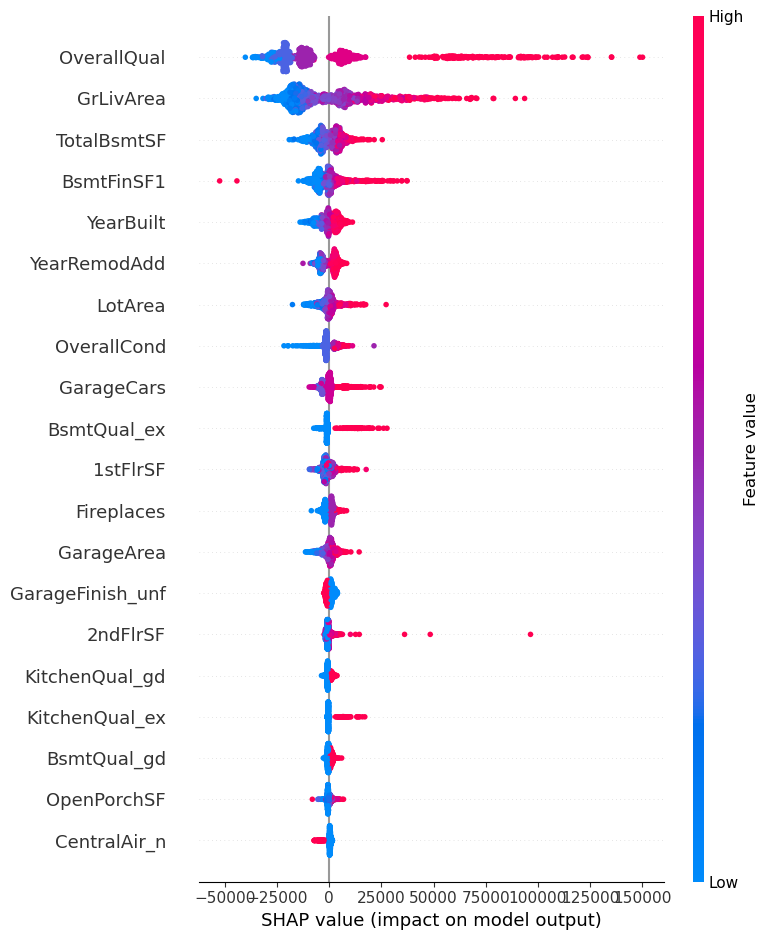

In [36]:
shap.summary_plot(shap_values, features=X_train, feature_names=df_model[feature_names].columns)

This is the prediction for 1 prediction

In [38]:
y.iloc[4]

SalePrice    250000
Name: 4, dtype: int64

In [39]:
shap.initjs()
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=df_model[feature_names].columns)

In [40]:
shap.initjs()
i = 10
shap.force_plot(explainer.expected_value, shap_values[i], features=X_test.iloc[i], feature_names=df_model[feature_names].columns)

In [41]:
y_test.iloc[10]

SalePrice    145000
Name: 576, dtype: int64

##### Random Forest Regressor

In [42]:
randforest  = RandomForestRegressor(random_state = 1)
randforest.fit(X_train, y_train)
pred =randforest.predict(X_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [43]:
print("Mean Absolute Error : " + str(mean_absolute_error(pred, y_test)))

Mean Absolute Error : 17977.739006849315


In [44]:
print("Mean Squared Error : " + str(mean_squared_error(y_test, pred, squared=False)))

Mean Squared Error : 29662.264235179216


In [45]:
MSE = mean_squared_error(y_test, pred, squared=False)

In [46]:
rsme = math.sqrt(MSE)  
print("Root Mean Square Error:")  
print(rsme)  

Root Mean Square Error:
172.2273620397735


In [47]:
explainer = shap.TreeExplainer(randforest, iteration_range=(0, 5))
shap_values = explainer.shap_values(X_train)

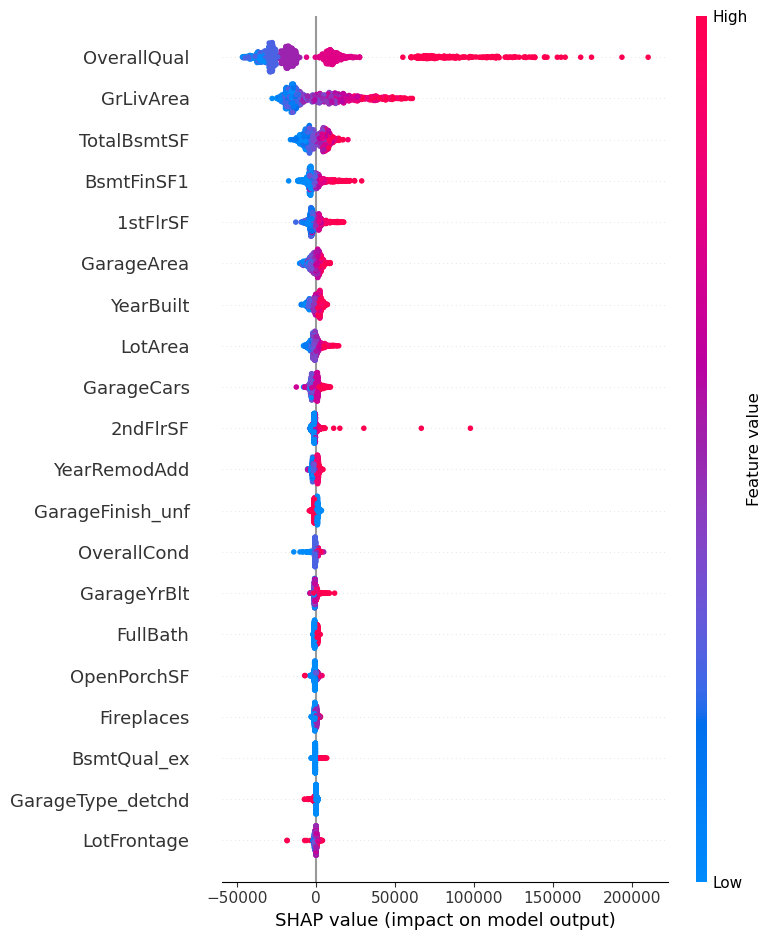

In [48]:
shap.summary_plot(shap_values, features=X_train, feature_names=df_model[feature_names].columns)